In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import efficientnet
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
path = Path(".")
data_path = path / ".." / ".." / ".." / "Dataset" / "Herlev Dataset"
data_path.ls()

[PosixPath('../../../Dataset/Herlev Dataset/best-rn34-herlev-multiclass-5fold.pkl'),
 PosixPath('../../../Dataset/Herlev Dataset/best-vgg19-herlev-multiclass-5fold.pkl'),
 PosixPath('../../../Dataset/Herlev Dataset/best-effb3-herlev-multiclass.pkl'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_moderate-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_superficiel'),
 PosixPath('../../../Dataset/Herlev Dataset/best-rn101-herlev-multiclass-5fold.pkl'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_light-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_severe-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_columnar'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_intermediate'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_carcinoma-in-situ'),
 PosixPath('../../../Dataset/Herlev Dataset/models'),
 PosixPath('../../../Dataset/Herlev Dataset/best-effb4-herlev-multiclass.pkl')]

In [4]:
data_init = (ImageList.from_folder(data_path)
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (917 items)
x: ImageList
Image (3, 83, 146),Image (3, 106, 116),Image (3, 129, 119),Image (3, 108, 110),Image (3, 209, 173)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../../Dataset/Herlev Dataset;

Test: None

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [6]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=30.0)

In [7]:
our_metrics = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
our_metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7fedf854e378>>,
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2),
 KappaScore(weights='quadratic')]

In [8]:
idxs = [[train_idx, val_idx] for train_idx, val_idx in skf.split(data_init.x.items, data_init.y.items)]

In [9]:
def model_callback(model, model_name):
    return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

# Fold-1

In [10]:
fold_idxs = idxs[0]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

In [11]:
learner = Learner(fold_data, efficientnet.EfficientNetB5(fold_data), metrics=our_metrics).to_fp16()
learner = learner.split([learner.model._conv_stem, learner.model._blocks, learner.model._conv_head])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /home/fadege/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


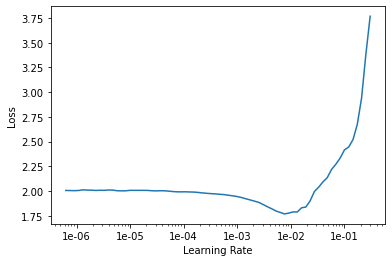

In [12]:
learner.lr_find()
learner.recorder.plot()

In [13]:
learner.fit_one_cycle(50, max_lr=slice(2e-03), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold1-stage1"))
learner.save("last-effb5-herlev-multiclass-fold1-stage1")

Better model found at epoch 0 with accuracy value: 0.125.
Better model found at epoch 1 with accuracy value: 0.15760870277881622.
Better model found at epoch 2 with accuracy value: 0.16304348409175873.
Better model found at epoch 3 with accuracy value: 0.17391304671764374.
Better model found at epoch 4 with accuracy value: 0.21195651590824127.
Better model found at epoch 5 with accuracy value: 0.30978259444236755.
Better model found at epoch 6 with accuracy value: 0.3913043439388275.
Better model found at epoch 7 with accuracy value: 0.42934781312942505.
Better model found at epoch 8 with accuracy value: 0.46739131212234497.
Better model found at epoch 9 with accuracy value: 0.47826087474823.
Better model found at epoch 12 with accuracy value: 0.4836956560611725.
Better model found at epoch 13 with accuracy value: 0.510869562625885.
Better model found at epoch 15 with accuracy value: 0.5489130616188049.
Better model found at epoch 21 with accuracy value: 0.570652186870575.
Better model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


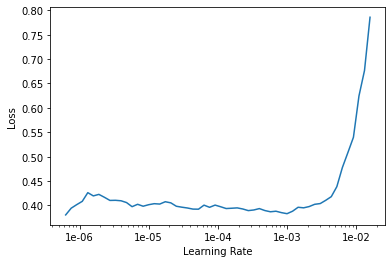

In [14]:
learner.load("best-effb5-herlev-multiclass-fold1-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot() 

In [15]:
learner.fit_one_cycle(50, max_lr=slice(4.2e-04), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold1-stage2"))
learner.save("last-effb5-herlev-multiclass-fold1-stage2")

Better model found at epoch 0 with accuracy value: 0.614130437374115.


# Fold-2

In [16]:
fold_idxs = idxs[1]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


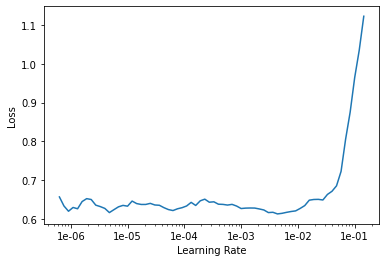

In [17]:
learner.load("best-effb5-herlev-multiclass-fold1-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [18]:
learner.fit_one_cycle(30, max_lr=slice(1e-03), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold2-stage1"))
learner.save("last-effb5-herlev-multiclass-fold2-stage1")

Better model found at epoch 0 with accuracy value: 0.929347813129425.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


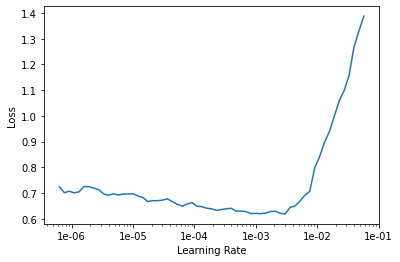

In [19]:
learner.load("best-effb5-herlev-multiclass-fold2-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(50, max_lr=slice(1e-04, 2e-04), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold2-stage2"))
learner.save("last-effb5-herlev-multiclass-fold2-stage2")

Better model found at epoch 0 with accuracy value: 0.929347813129425.
Better model found at epoch 1 with accuracy value: 0.9347826242446899.
Better model found at epoch 4 with accuracy value: 0.9402173757553101.
Better model found at epoch 7 with accuracy value: 0.945652186870575.


# Fold-3

In [21]:
fold_idxs = idxs[2]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


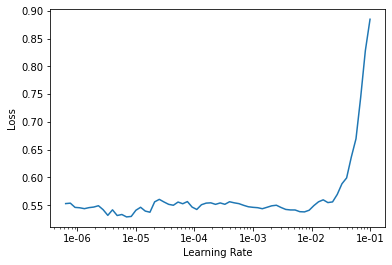

In [22]:
learner.load("best-effb5-herlev-multiclass-fold2-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [23]:
learner.fit_one_cycle(30, max_lr=slice(2.5e-03), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold3-stage1"))
learner.save("last-effb5-herlev-multiclass-fold3-stage1")

Better model found at epoch 0 with accuracy value: 0.9781420826911926.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


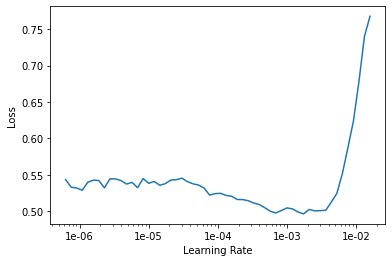

In [24]:
learner.load("best-effb5-herlev-multiclass-fold3-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [25]:
learner.fit_one_cycle(40, max_lr=slice(2.5e-04), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold3-stage2"))
learner.save("last-effb5-herlev-multiclass-fold3-stage2")

Better model found at epoch 0 with accuracy value: 0.9781420826911926.


# Fold-4

In [26]:
fold_idxs = idxs[3]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


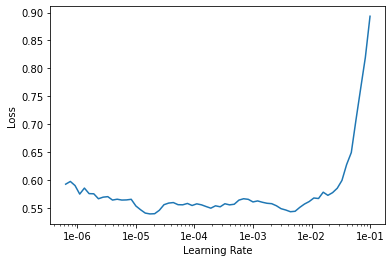

In [27]:
learner.load("best-effb5-herlev-multiclass-fold3-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [28]:
learner.fit_one_cycle(30, max_lr=slice(8.5e-06), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold4-stage1"))
learner.save("last-effb5-herlev-multiclass-fold4-stage1")

Better model found at epoch 0 with accuracy value: 0.9726775884628296.
Better model found at epoch 4 with accuracy value: 0.9781420826911926.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


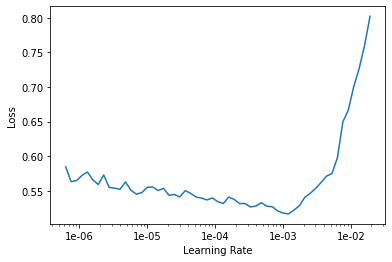

In [29]:
learner.load("best-effb5-herlev-multiclass-fold4-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [30]:
learner.fit_one_cycle(40, max_lr=slice(5e-04), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold4-stage2"))
learner.save("last-effb5-herlev-multiclass-fold4-stage2")

Better model found at epoch 0 with accuracy value: 0.9726775884628296.
Better model found at epoch 1 with accuracy value: 0.9781420826911926.


# Fold-5

In [31]:
fold_idxs = idxs[4]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


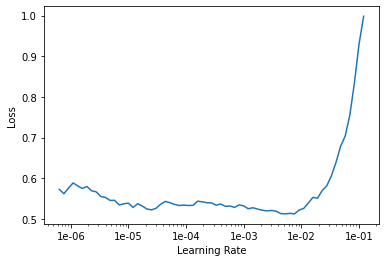

In [32]:
learner.load("best-effb5-herlev-multiclass-fold4-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [33]:
learner.fit_one_cycle(30, max_lr=slice(2e-03), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold5-stage1"))
learner.save("last-effb5-herlev-multiclass-fold5-stage1")

Better model found at epoch 0 with accuracy value: 0.9836065769195557.
Better model found at epoch 1 with accuracy value: 0.9890710115432739.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


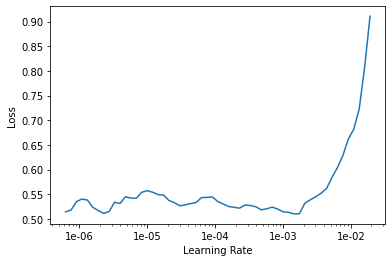

In [34]:
learner.load("best-effb5-herlev-multiclass-fold5-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [35]:
learner.fit_one_cycle(30, max_lr=slice(6.5e-04), callbacks=model_callback(learner, "best-effb5-herlev-multiclass-fold5-stage2"))
learner.save("last-effb5-herlev-multiclass-fold5-stage2")

Better model found at epoch 0 with accuracy value: 0.9781420826911926.
Better model found at epoch 2 with accuracy value: 0.9836065769195557.


In [36]:
learner.load("best-effb5-herlev-multiclass-fold5-stage2")
learner.freeze()
learner.export("best-effb5-herlev-multiclass.pkl")